In [6]:
import numpy as np
import rpy2
import sklearn
from sklearn import linear_model
import warnings
warnings.filterwarnings("ignore")

%reload_ext rpy2.ipython

In [7]:
%%R -o y,X
################################################################################
# Initialize local settings
################################################################################

# Specify options
options(scipen=999)

In [8]:
%%R
################################################################################
# Load dependencies
################################################################################

# Install packages
if (!require('dplyr')) install.packages('dplyr', quiet=T)
if (!require('glmnet')) install.packages('glmnet', quiet=T)
if (!require('SVMMaj')) install.packages('SVMMaj', quiet=T)

# Load dependencies
source('elastic.net.lm.R')
source('grid.search.cross.validation.R')
source('ridge.lm.R')

In [9]:
%%R -o y,X
################################################################################
# Generate results
################################################################################

# Load data
df = SVMMaj::supermarket1996; df = df[sort(colnames(df))]
df = subset(df, select=-c(CITY, GROCCOUP_sum, SHPINDX, STORE, ZIP))

# Define dependent and independent variables
dep.var = 'GROCERY_sum'; y = df[dep.var]; X = df[colnames(df) != dep.var]

# OPTIONAL: Remove duplicate columns
while (any(duplicated(t(X)))) X = X[, -min(which(duplicated(t(X))))]

# Specify hyperparameter values to consider
params.list = list(
  'alpha' = seq(0, 1, length.out=100),
  'lambda' = 10 ^ seq(-5, 5, length.out=100)
)

# Specify fold ids
N = nrow(X); n.folds = 5; fold.id = ((1:N) %% n.folds + 1)[sample(N, N)]

# Define metric functions
lm.mse.scale = function(X, y, beta) mean(sum(scale(y) - scale(X) %*% beta) ^ 2)
root.mean = function(x) sqrt(mean(x))

# Hyperparameter tuning using grid search 5-fold cross-validation
gscv.res = grid.search.cross.validation(scale(X), scale(y), elastic.net.lm,
  params.list, n.folds=n.folds, ind.metric=lm.mse.scale, comb.metric=root.mean,
  fold.id=fold.id, verbose=T, intercept=F, standardize=F)

# Compare outcome with glmnet package
cv.fit = cv.glmnet(scale(X), scale(y), nfolds=n.folds, foldid=fold.id,
  gamma=params.list$alpha, lambda=params.list$lambda)

|===================================================== |100% ~0 s remainingg                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [10]:
%%R
# Display optimal hyperparameters
cat('Optimal lambda: ', cv.fit$lambda.min, '\n')
cat('Optimal lambda: ', gscv.res$lambda, '\nOptimal alpha:  ',
  gscv.res$alpha, '\n')

Optimal lambda:  0.02718588 
Optimal lambda:  58.57021 
Optimal alpha:   0.7676768 


In [21]:
%%R
# Estimate model on all data for optimal values of lambda and alpha
elastic.net.lm(scale(X), scale(y), alpha=gscv.res$alpha, lambda=gscv.res$lambda)

$coefficients
           GROCERY_sum
AGE60     0.0022894526
AGE9      0.0032876982
DENSITY  -0.0036355611
EDUC      0.0113856178
ETHNIC   -0.0061804014
HH3PLUS  -0.0002323167
HH4PLUS  -0.0013463250
HHLARGE  -0.0076037168
HHSINGLE -0.0071122739
HSIZE2    0.0071480455
HSIZE34   0.0033671014
HSIZEAVG -0.0015252889
HVAL150   0.0142879526
HVAL200   0.0162220126
HVALMEAN  0.0132898990
INCOME    0.0089625238
INCSIGMA  0.0134162450
MORTGAGE -0.0082973038
NOCAR    -0.0022043462
NWHITE   -0.0086287637
NWRKCH    0.0037030232
NWRKCH17  0.0109018074
NWRKCH5  -0.0028808425
POVERTY  -0.0031373483
RETIRED   0.0042668401
SHOPINDX  0.0024472327
SHPAVID  -0.0113966384
SHPBIRD   0.0038896740
SHPCONS  -0.0036217493
SHPHURR   0.0091160989
SHPKSTR  -0.0123073481
SHPUNFT   0.0051219377
SINGLE   -0.0080086581
SINHOUSE  0.0059093282
TELEPHN   0.0010538499
UNEMP     0.0035322868
WORKWOM  -0.0090765340
WRKCH    -0.0087295587
WRKCH17  -0.0033583462
WRKCH5   -0.0146195865
WRKWCH   -0.0146652301
WRKWNCH  -0.00503004

In [20]:
%%R
glmnet(scale(X), scale(y), alpha=gscv.res$alpha, lambda=gscv.res$lambda)


Call:  glmnet(x = scale(X), y = scale(y), alpha = gscv.res$alpha, lambda = gscv.res$lambda) 

  Df %Dev Lambda
1  0    0  58.57


43 x 1 sparse Matrix of class "dgCMatrix"
                                    1
(Intercept)  0.0000000000000001152674
AGE60        .                       
AGE9         0.3997206213514875039472
DENSITY     -0.0962595523519049894867
EDUC         .                       
ETHNIC       .                       
HH3PLUS      .                       
HH4PLUS      .                       
HHLARGE     -0.2112743245877250208853
HHSINGLE     .                       
HSIZE2       0.0227283775843829215224
HSIZE34      0.0942983953708927125081
HSIZEAVG     .                       
HVAL150      0.2183870424612634197903
HVAL200      .                       
HVALMEAN     .                       
INCOME       .                       
INCSIGMA     .                       
MORTGAGE    -0.2030947690315519360560
NOCAR        .                       
NWHITE       .                       
NWRKCH       .                       
NWRKCH17     .                       
NWRKCH5      .                       
POVERTY 

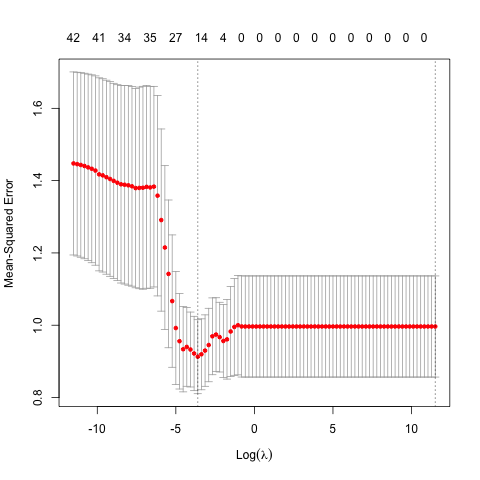

In [12]:
%%R
# Display glmnet results
plot(cv.fit)
coef(cv.fit, s = "lambda.min")

In [13]:
df_y = y
df_X = X
y_scale = sklearn.preprocessing.scale(y.values)
X_scale = sklearn.preprocessing.scale(X.values)

In [14]:
params_list = {
  'alpha' : np.linspace(0, 1, 100),
  'lambda' : np.power(10, np.linspace(-5, 5, 100)),
}

In [ ]:
print(params_list['lambda'])

In [15]:
res = linear_model.ElasticNetCV(
  l1_ratio = params_list['alpha'],
  alphas = params_list['lambda'],
  fit_intercept = False,
  normalize = False,
  tol = 10e-6,
  cv = 5,
  n_jobs = -1,
).fit(X_scale, y_scale)

In [16]:
print('Optimal alpha:  {:.8f}'.format(res.l1_ratio_))
print('Optimal lambda: {:.8f}'.format(res.alpha_))

Optimal alpha:  0.00000000
Optimal lambda: 0.70548023


In [28]:
np.hstack((res.intercept_, res.coef_))

array([ 0.        ,  0.00775162,  0.09279179, -0.05093667,  0.04696375,
        0.00323275,  0.01493196, -0.00076782, -0.05790429, -0.02946952,
        0.03889506,  0.05077929, -0.0037185 ,  0.07306202,  0.06952397,
        0.05517349,  0.02747824,  0.02104952, -0.07372291,  0.03582557,
       -0.03999258,  0.03148467,  0.04258257,  0.01658677,  0.03541219,
        0.03487899,  0.00227327, -0.04659233,  0.00716912,  0.03408112,
        0.06407997, -0.03806747, -0.02797976, -0.00915152,  0.03696235,
        0.01255407,  0.09682896, -0.02658054, -0.03227873,  0.00367439,
       -0.07525828, -0.07524722, -0.02879244])

In [30]:
import rpy2.robjects as robjects
r = robjects.r
r.source('EBDS20102 - Assignment 2.R')

|======================================================|100% ~0 s remainingg                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

R[write to console]: Error in grid.search.cross.validation(scale(x), scale(y), glmnet, params.list,  : 
  object 'best.params' not found

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



RRuntimeError: Error in grid.search.cross.validation(scale(x), scale(y), glmnet, params.list,  : 
  object 'best.params' not found
